# 1. Define binning and model

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 25

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [4]:
## Loading Ntuples
columns = util.all_relevant_variables + ['B0_CMS4_weMissM2']

# Load template samples
e_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb/*.root:B0'],
                          library="np",
                          #cut=input_cut,
                          filter_branch=lambda branch: branch.name in columns)

df_e = pd.DataFrame(e_temp)

# mu_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/mu_channel/MC15ri_local_200fb/*.root:B0'],
#                           library="np",
#                           #cut=input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mu = pd.DataFrame(mu_temp)

In [5]:
# load MVA
import lightgbm as lgb
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob==largest_prob and signal_prob>0.8 and \
continuum_prob<0.04 and fakeD_prob<0.05'

df_e.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_e.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

pred_e = bst_lgb.predict(df_e[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_e = pd.DataFrame(pred_e, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_e = pd.concat([df_e, lgb_out_e], axis=1)
df_lgb_e['largest_prob'] = df_lgb_e[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_e, lgb_out_e

df_cut_e=df_lgb_e.query(cut)
df_bestSelected_e=df_cut_e.loc[df_cut_e.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [6]:
te=util.get_dataframe_samples_new(df_bestSelected_e, 'e', template=False)
# tmu=util.get_dataframe_samples_new(df_mu, 'mu', template=False)

for name, df in te.items():
    print(name, len(df))
# print()
# for name, df in tmu.items():
#     print(name, len(df))

bkg_FakeD 16626
bkg_TDFl 919
bkg_fakeTracks 496
bkg_continuum 1455
bkg_combinatorial 2376
bkg_singleBbkg 1404
bkg_other_TDTl 0
$D\tau\nu$ 1016
$D^\ast\tau\nu$ 530
$D\ell\nu$ 14129
$D^\ast\ell\nu$ 9377
$D^{\ast\ast}\tau\nu$ 305
$D^{\ast\ast}\ell\nu$ 5333
$D\ell\nu$_gap 1105
bkg_other_signal 0


In [7]:
## Asimov test
indices_threshold_3,temp_asimov_e,temp_asimov_merged_e = util.create_templates(
    samples=te, bins=[MM2_bins, p_D_l_bins], 
    variables=['B0_CMS4_weMissM2','p_D_l'],
    bin_threshold=1,merge_threshold=10)
(template_flat_e,staterr_flat_e,asimov_data_e) = temp_asimov_e
(template_flat_e_merged,staterr_flat_e_merged,asimov_data_e_merged) = temp_asimov_merged_e

original template length = 389
new template length = 289


In [8]:
## MC test
## Create data histogram
(d_histogram, xedges, yedges) = np.histogram2d(df_test['B0_CMS3_weMissM2'], 
                                               df_test['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=df_test['__weight__'])
d_histogram = d_histogram.T
    
# indices_threshold = np.where(np.sum(list(t_histograms.values()),axis=0) >= bin_threshold)
# template_flat = {name:list(t[indices_threshold]) for name,t in t_histograms.items()}
# staterr_flat = {name:list(se[indices_threshold]) for name,se in t_staterr.items()}
# data = counts.ravel().to_list()
data_flat = list(d_histogram[indices_threshold])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


# 2. Create a pyhf workspace

In [17]:
workspace_path = '../Toys_pipeline/2d_ws_SR_1ch_50_25.json'
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        0.0,
                        2.0,
                        4.0,
                        3.0,
                        4.0,
                        2.0,
                        1.0,
                        1.0,
                        3.0,
                        5.0,
                        15.0,
                        12.0,
                        20.0,
                        23.0,
                        15.0,
                        5.0,
                        1.0,
                        0.0,
                        2.0,
                        1.0,
                        5.0,
                        11.0,
                        18.0,
                        22.0,
                        30.0,
                        40.0,
                        42.0,
                        37.0,
                        21.0,
           

In [22]:
# update templates and data in the workspace
# signal region
spec = util.update_workspace(workspace=spec,
                             temp_asimov_sets=[temp_asimov_e],
                             staterror=False,
                             exclude_sample=['bkg_FakeD','bkg_continuum',
                                             "bkg_TDFl", 'bkg_combinatorial',
                                             'bkg_singleBbkg'])

print(json.dumps(spec, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec, '../Toys_pipeline/2d_ws_SR_1ch_noStaterror_noBkg_50_25.json')

DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/2d_ws_SR_1ch_50_25.json


{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        0.0,
                        2.0,
                        4.0,
                        3.0,
                        4.0,
                        2.0,
                        1.0,
                        1.0,
                        3.0,
                        5.0,
                        15.0,
                        12.0,
                        20.0,
                        23.0,
                        15.0,
                        5.0,
                        1.0,
                        0.0,
                        2.0,
                        1.0,
                        5.0,
                        11.0,
                        18.0,
                        22.0,
                        30.0,
                        40.0,
                        42.0,
                        37.0,
                        21.0,
           

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_FakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_

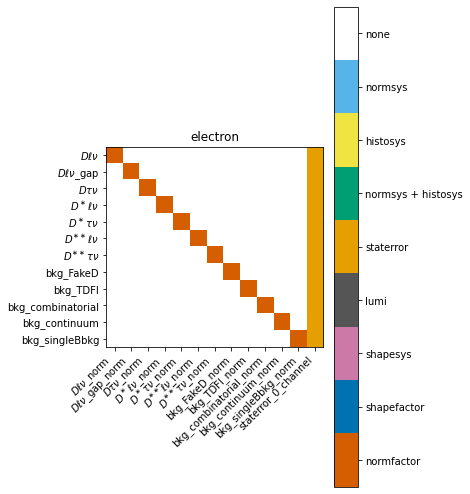

In [18]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [19]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_FakeD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_

In [28]:
toy_pars = model.config.suggested_init()
# rng = np.random.default_rng(0)
# toy_pars[:8] = list(rng.uniform(0.01,0.2,8))
# minos_parameters = model.config.parameters[:8]
# minos_parameters.remove('bkg_fakeD_norm')
        
# generate the toys:
pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))
toys = pdf_toy.sample((2,))
fix_par = [False,False,False,False,False,False,False,True,True,True,True,True]
toy_pars[:7]

[1, 1, 1, 1, 1, 1, 1]

In [29]:
pyhf.set_backend('jax', 'scipy')
init_pars = pyhf.infer.mle.fit(data=toys[1], pdf=model,
                               init_pars=toy_pars,
                               fixed_params=fix_par).tolist()
init_pars[:12]

[1.0251134126190533,
 0.8254889174360075,
 1.9252023051046212,
 0.9327736361847141,
 0.19211357961710854,
 1.039924431682683,
 0.6660226713055969,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [30]:
pyhf.set_backend('jax', 'minuit')
res = cabinetry.fit.fit(
    model,
    data=toys[0],
    init_pars=toy_pars,
    fix_pars = fix_par,
    # par_bounds=par_bounds,
    goodness_of_fit=True,
#     minos=minos_parameters
)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1762                       │       Nfcn = 81465, Ngrad = 18       │
│ EDM = 0.00067 (Goal: 0.0002)     │           time = 37.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - staterror_0_channel[88]    =  2.0243 +/- 0.8146
INFO - cabinetry.fit - staterror_0_channel[89]    =  1.3753 +/- 0.9873
INFO - cabinetry.fit - staterror_0_channel[90]    =  0.4691 +/- 0.2756
INFO - cabinetry.fit - staterror_0_channel[91]    =  0.7425 +/- 0.2491
INFO - cabinetry.fit - staterror_0_channel[92]    =  0.9067 +/- 0.2775
INFO - cabinetry.fit - staterror_0_channel[93]    =  0.8423 +/- 0.1452
INFO - cabinetry.fit - staterror_0_channel[94]    =  1.0544 +/- 0.1563
INFO - cabinetry.fit - staterror_0_channel[95]    =  0.9086 +/- 0.1045
INFO - cabinetry.fit - staterror_0_channel[96]    =  0.8663 +/- 0.0972
INFO - cabinetry.fit - staterror_0_channel[97]    =  0.9370 +/- 0.0805
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0638 +/- 0.0739
INFO - cabinetry.fit - staterror_0_channel[99]    =  0.9390 +/- 0.0631
INFO - cabinetry.fit - staterror_0_channel[100]   =  1.0591 +/- 0.0586
INFO - cabinetry.fit - staterror_0_channel[101]   =  0.9686 +/- 0.0530
INFO -

INFO - cabinetry.fit - staterror_0_channel[204]   =  0.8593 +/- 0.1375
INFO - cabinetry.fit - staterror_0_channel[205]   =  0.6566 +/- 0.9727
INFO - cabinetry.fit - staterror_0_channel[206]   =  0.6470 +/- 0.5388
INFO - cabinetry.fit - staterror_0_channel[207]   =  0.0000 +/- 1.7173
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.1570 +/- 0.6291
INFO - cabinetry.fit - staterror_0_channel[209]   =  1.2410 +/- 0.3800
INFO - cabinetry.fit - staterror_0_channel[210]   =  0.2302 +/- 1.0235
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.3367 +/- 0.2033
INFO - cabinetry.fit - staterror_0_channel[212]   =  0.9786 +/- 0.1413
INFO - cabinetry.fit - staterror_0_channel[213]   =  0.7883 +/- 0.1134
INFO - cabinetry.fit - staterror_0_channel[214]   =  1.0150 +/- 0.1065
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0246 +/- 0.0706
INFO - cabinetry.fit - staterror_0_channel[216]   =  0.9790 +/- 0.0547
INFO - cabinetry.fit - staterror_0_channel[217]   =  0.9734 +/- 0.0418
INFO -

INFO - cabinetry.fit - staterror_0_channel[320]   =  1.1408 +/- 0.5135
INFO - cabinetry.fit - staterror_0_channel[321]   =  0.0003 +/- 6.5100
INFO - cabinetry.fit - staterror_0_channel[322]   =  1.2280 +/- 0.4621
INFO - cabinetry.fit - staterror_0_channel[323]   =  0.0000 +/- 0.6080
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0616 +/- 0.7211
INFO - cabinetry.fit - staterror_0_channel[325]   =  0.0004 +/- 6.7732
INFO - cabinetry.fit - staterror_0_channel[326]   =  1.2970 +/- 0.7846
INFO - cabinetry.fit - staterror_0_channel[327]   =  0.7246 +/- 0.9753
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.6840 +/- 0.4570
INFO - cabinetry.fit - staterror_0_channel[329]   =  0.7994 +/- 0.2183
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0490 +/- 0.2293
INFO - cabinetry.fit - staterror_0_channel[331]   =  0.8250 +/- 0.1358
INFO - cabinetry.fit - staterror_0_channel[332]   =  0.9991 +/- 0.0819
INFO - cabinetry.fit - staterror_0_channel[333]   =  0.9872 +/- 0.0607
INFO -

In [ ]:
# store_full=True

# # prepare containers for fit results
# fit_results = {
#     'best_twice_nll': [],
#     'pval': [],
#     'best_fit': []
# }
# if store_full:
# #             fit_results['main_data'] = []
# #             fit_results['aux_data'] = []
#     fit_results['uncertainty'] = []
#     fit_results['minos_uncertainty_up'] = []
#     fit_results['minos_uncertainty_down'] = []
#     minos_parameters = model.config.par_names[:8]

# failed_fits = 0
# attempted_fits = 0
# successful_fits = 0

# # fit toys
# with tqdm(total=len(toys), desc='Fitting toys') as pbar:
#     while attempted_fits < len(toys):
#         data = toys[attempted_fits]

#         try:
#             if store_full: # minuit and minos
#                 try:
#                     pyhf.set_backend('jax', 'scipy')
#                     init_pars = pyhf.infer.mle.fit(data=data, pdf=model,fixed_params=fix_par).tolist()

#                 except:
#                     init_pars = toy_pars


#                 pyhf.set_backend('jax', 'minuit')
#                 res = cabinetry.fit.fit(
#                     model,
#                     data=data,
#                     init_pars=init_pars,
#                     fix_pars = fix_par,
#                     # par_bounds=par_bounds,
#                     goodness_of_fit=True,
#                     minos=minos_parameters,
#                 )

#                 # save fit results
#                 fit_results['best_twice_nll'].append(res.best_twice_nll)
#                 fit_results['pval'].append(res.goodness_of_fit)
#                 fit_results['best_fit'].append(res.bestfit[:8].tolist())

#                 main_data, aux_data = model.fullpdf_tv.split(pyhf.tensorlib.astensor(data))
# #                         fit_results['main_data'].append(main_data.tolist())
# #                         fit_results['aux_data'].append(aux_data.tolist())
#                 fit_results['uncertainty'].append(res.uncertainty[:8].tolist())

#                 fit_results['minos_uncertainty_up'].append(
#                     [abs(res.minos_uncertainty[x][1]) for x in res.labels[:8]])
#                 fit_results['minos_uncertainty_down'].append(
#                     [abs(res.minos_uncertainty[x][0]) for x in res.labels[:8]])

#             else: # scipy only
#                 pyhf.set_backend('jax', 'scipy')
#                 bestfit_pars, twice_nll = pyhf.infer.mle.fit(data=data, pdf=model, 
#                                                              return_fitted_val=True,
#                                                              fixed_params=fix_par)

#                 # save fit results
#                 fit_results['best_twice_nll'].append(twice_nll.tolist())
#                 fit_results['best_fit'].append(bestfit_pars[:8].tolist())

#             successful_fits += 1
#             pbar.update(1)

#         except:
#             failed_fits += 1
#         attempted_fits += 1
#     pbar.close()

# for key in fit_results.keys():
#     # convert to json safe lists (these are much quicker to load then the yaml files later)
#     fit_results[key] = np.array(fit_results[key]).tolist()

# out_dict = {
#     'poi': model.config.par_names[:8],
#     'toy_pars': toy_pars[:8],
#     'results': fit_results,
#     'failed_fits': failed_fits,
#     'atempted_fits': attempted_fits
#                          }

In [19]:
out_dict

{'poi': ['$D\\ell\\nu$_norm',
  '$D\\tau\\nu$_norm',
  '$D^\\ast\\ell\\nu$_norm',
  '$D^\\ast\\tau\\nu$_norm',
  '$D^{\\ast\\ast}\\tau\\nu$_norm',
  'bkg_fakeD_norm',
  'gap_non_$D^{\\ast\\ast}\\ell\\nu$_norm',
  'res_$D^{\\ast\\ast}\\ell\\nu$_norm'],
 'toy_pars': [0.1310227205910763,
  0.06125947561513536,
  0.01778496954787699,
  0.013140250750420529,
  0.16452134544805178,
  0.18342355968276713,
  0.12526079739576418,
  0.1486043465869597],
 'results': {'best_twice_nll': [],
  'pval': [],
  'best_fit': [],
  'uncertainty': [],
  'minos_uncertainty_up': [],
  'minos_uncertainty_down': []},
 'failed_fits': 5,
 'atempted_fits': 5}

DEBUG - cabinetry.model_utils - total stdev is [[1.73, 1.41, 2.45, 2.45, 2.83, 1, 2.24, ..., 1.41, 3, 5.39, 1, 1, 2.24, 1]]
DEBUG - cabinetry.model_utils - total stdev per channel is [234]
INFO - cabinetry.visualize.utils - saving figure as figures/electron_prefit.pdf


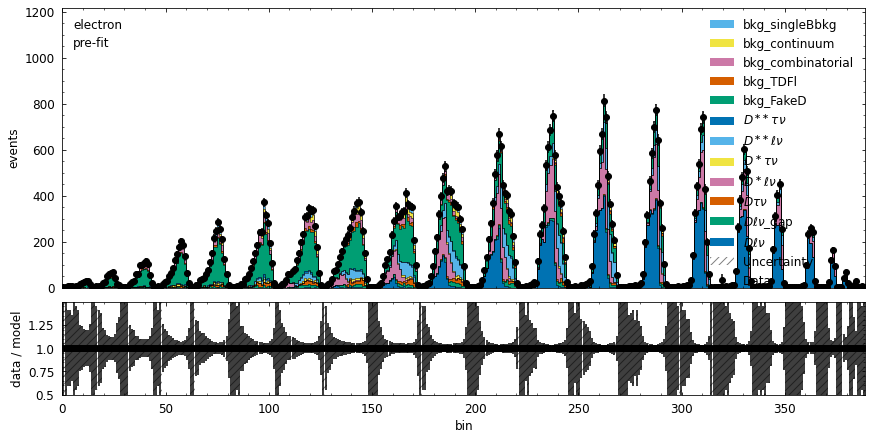

In [20]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

DEBUG - cabinetry.model_utils - total stdev is [[1, 2.24, 1.41, 2.24, 1.73, 1.41, 2.65, ..., 5.2, 1, 2, 3.87, 1, 1, 1], ...]
DEBUG - cabinetry.model_utils - total stdev per channel is [300, 300]
INFO - cabinetry.visualize.utils - saving figure as figures/e_channel_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/mu_channel_prefit.pdf


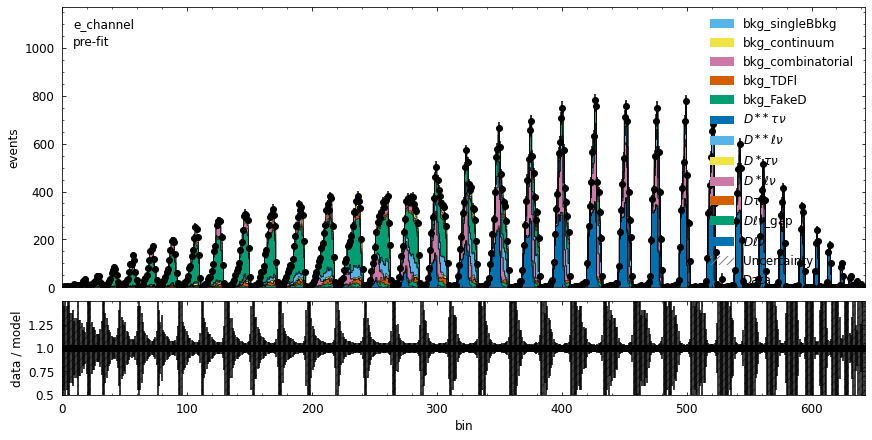

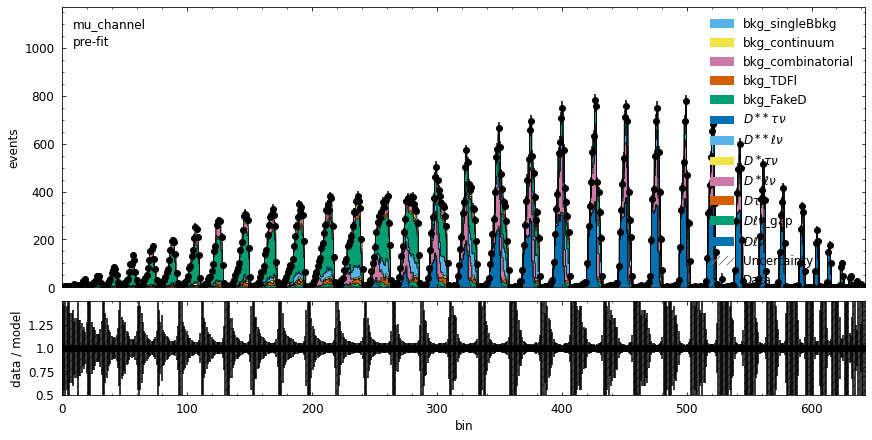

In [21]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [22]:
%%time
## Asimov test with 333/fb
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4764                       │            Nfcn = 849541             │
│ EDM = 2.32e-08 (Goal: 0.0002)    │          time = 2282.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4763.821745 at

INFO - cabinetry.fit - staterror_e_channel[89]    =  1.0000 +/- 0.0519
INFO - cabinetry.fit - staterror_e_channel[90]    =  1.0000 +/- 0.0603
INFO - cabinetry.fit - staterror_e_channel[91]    =  1.0000 +/- 0.0926
INFO - cabinetry.fit - staterror_e_channel[92]    =  1.0000 +/- 0.1669
INFO - cabinetry.fit - staterror_e_channel[93]    =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_e_channel[94]    =  1.0000 +/- 0.4090
INFO - cabinetry.fit - staterror_e_channel[95]    =  1.0000 +/- 0.4075
INFO - cabinetry.fit - staterror_e_channel[96]    =  1.0000 +/- 0.1967
INFO - cabinetry.fit - staterror_e_channel[97]    =  1.0000 +/- 0.1669
INFO - cabinetry.fit - staterror_e_channel[98]    =  1.0000 +/- 0.1479
INFO - cabinetry.fit - staterror_e_channel[99]    =  1.0000 +/- 0.1296
INFO - cabinetry.fit - staterror_e_channel[100]   =  1.0000 +/- 0.1024
INFO - cabinetry.fit - staterror_e_channel[101]   =  1.0000 +/- 0.0789
INFO - cabinetry.fit - staterror_e_channel[102]   =  1.0000 +/- 0.0752
INFO -

INFO - cabinetry.fit - staterror_e_channel[205]   =  1.0000 +/- 0.0674
INFO - cabinetry.fit - staterror_e_channel[206]   =  1.0000 +/- 0.0637
INFO - cabinetry.fit - staterror_e_channel[207]   =  1.0000 +/- 0.0552
INFO - cabinetry.fit - staterror_e_channel[208]   =  1.0000 +/- 0.0522
INFO - cabinetry.fit - staterror_e_channel[209]   =  1.0000 +/- 0.0474
INFO - cabinetry.fit - staterror_e_channel[210]   =  1.0000 +/- 0.0441
INFO - cabinetry.fit - staterror_e_channel[211]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[212]   =  1.0000 +/- 0.0382
INFO - cabinetry.fit - staterror_e_channel[213]   =  1.0000 +/- 0.0398
INFO - cabinetry.fit - staterror_e_channel[214]   =  1.0000 +/- 0.0368
INFO - cabinetry.fit - staterror_e_channel[215]   =  1.0000 +/- 0.0370
INFO - cabinetry.fit - staterror_e_channel[216]   =  1.0000 +/- 0.0446
INFO - cabinetry.fit - staterror_e_channel[217]   =  1.0000 +/- 0.0638
INFO - cabinetry.fit - staterror_e_channel[218]   =  1.0000 +/- 0.1548
INFO -

INFO - cabinetry.fit - staterror_e_channel[321]   =  1.0000 +/- 0.0375
INFO - cabinetry.fit - staterror_e_channel[322]   =  1.0000 +/- 0.0317
INFO - cabinetry.fit - staterror_e_channel[323]   =  1.0000 +/- 0.0297
INFO - cabinetry.fit - staterror_e_channel[324]   =  1.0000 +/- 0.0310
INFO - cabinetry.fit - staterror_e_channel[325]   =  1.0000 +/- 0.0342
INFO - cabinetry.fit - staterror_e_channel[326]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_e_channel[327]   =  1.0000 +/- 0.0349
INFO - cabinetry.fit - staterror_e_channel[328]   =  1.0000 +/- 0.0392
INFO - cabinetry.fit - staterror_e_channel[329]   =  1.0000 +/- 0.0396
INFO - cabinetry.fit - staterror_e_channel[330]   =  1.0000 +/- 0.0426
INFO - cabinetry.fit - staterror_e_channel[331]   =  1.0000 +/- 0.0512
INFO - cabinetry.fit - staterror_e_channel[332]   =  1.0000 +/- 0.0725
INFO - cabinetry.fit - staterror_e_channel[333]   =  1.0000 +/- 0.3530
INFO - cabinetry.fit - staterror_e_channel[334]   =  1.0000 +/- 0.7007
INFO -

INFO - cabinetry.fit - staterror_e_channel[437]   =  1.0000 +/- 0.3539
INFO - cabinetry.fit - staterror_e_channel[438]   =  1.0000 +/- 0.2136
INFO - cabinetry.fit - staterror_e_channel[439]   =  1.0000 +/- 0.2884
INFO - cabinetry.fit - staterror_e_channel[440]   =  1.0000 +/- 0.2504
INFO - cabinetry.fit - staterror_e_channel[441]   =  1.0000 +/- 0.2239
INFO - cabinetry.fit - staterror_e_channel[442]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[443]   =  1.0000 +/- 0.1581
INFO - cabinetry.fit - staterror_e_channel[444]   =  1.0000 +/- 0.1624
INFO - cabinetry.fit - staterror_e_channel[445]   =  1.0000 +/- 0.0760
INFO - cabinetry.fit - staterror_e_channel[446]   =  1.0000 +/- 0.0467
INFO - cabinetry.fit - staterror_e_channel[447]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[448]   =  1.0000 +/- 0.0342
INFO - cabinetry.fit - staterror_e_channel[449]   =  1.0000 +/- 0.0305
INFO - cabinetry.fit - staterror_e_channel[450]   =  1.0000 +/- 0.0266
INFO -

INFO - cabinetry.fit - staterror_e_channel[553]   =  1.0000 +/- 0.4074
INFO - cabinetry.fit - staterror_e_channel[554]   =  1.0000 +/- 0.5004
INFO - cabinetry.fit - staterror_e_channel[555]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[556]   =  1.0000 +/- 0.1962
INFO - cabinetry.fit - staterror_e_channel[557]   =  1.0000 +/- 0.1215
INFO - cabinetry.fit - staterror_e_channel[558]   =  1.0000 +/- 0.0486
INFO - cabinetry.fit - staterror_e_channel[559]   =  1.0000 +/- 0.0371
INFO - cabinetry.fit - staterror_e_channel[560]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_e_channel[561]   =  1.0000 +/- 0.0313
INFO - cabinetry.fit - staterror_e_channel[562]   =  1.0000 +/- 0.0372
INFO - cabinetry.fit - staterror_e_channel[563]   =  1.0000 +/- 0.0868
INFO - cabinetry.fit - staterror_e_channel[564]   =  1.0000 +/- 0.7091
INFO - cabinetry.fit - staterror_e_channel[565]   =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_e_channel[566]   =  1.0000 +/- 0.7025
INFO -

INFO - cabinetry.fit - staterror_mu_channel[26]   =  1.0000 +/- 0.1401
INFO - cabinetry.fit - staterror_mu_channel[27]   =  1.0000 +/- 0.1038
INFO - cabinetry.fit - staterror_mu_channel[28]   =  1.0000 +/- 0.1036
INFO - cabinetry.fit - staterror_mu_channel[29]   =  1.0000 +/- 0.1038
INFO - cabinetry.fit - staterror_mu_channel[30]   =  1.0000 +/- 0.1449
INFO - cabinetry.fit - staterror_mu_channel[31]   =  1.0000 +/- 0.2045
INFO - cabinetry.fit - staterror_mu_channel[32]   =  1.0000 +/- 0.4979
INFO - cabinetry.fit - staterror_mu_channel[33]   =  1.0000 +/- 0.7027
INFO - cabinetry.fit - staterror_mu_channel[34]   =  1.0000 +/- 0.2674
INFO - cabinetry.fit - staterror_mu_channel[35]   =  1.0000 +/- 0.2237
INFO - cabinetry.fit - staterror_mu_channel[36]   =  1.0000 +/- 0.1776
INFO - cabinetry.fit - staterror_mu_channel[37]   =  1.0000 +/- 0.1341
INFO - cabinetry.fit - staterror_mu_channel[38]   =  1.0000 +/- 0.1187
INFO - cabinetry.fit - staterror_mu_channel[39]   =  1.0000 +/- 0.0931
INFO -

INFO - cabinetry.fit - staterror_mu_channel[142]  =  1.0000 +/- 0.0571
INFO - cabinetry.fit - staterror_mu_channel[143]  =  1.0000 +/- 0.0517
INFO - cabinetry.fit - staterror_mu_channel[144]  =  1.0000 +/- 0.0460
INFO - cabinetry.fit - staterror_mu_channel[145]  =  1.0000 +/- 0.0415
INFO - cabinetry.fit - staterror_mu_channel[146]  =  1.0000 +/- 0.0410
INFO - cabinetry.fit - staterror_mu_channel[147]  =  1.0000 +/- 0.0411
INFO - cabinetry.fit - staterror_mu_channel[148]  =  1.0000 +/- 0.0426
INFO - cabinetry.fit - staterror_mu_channel[149]  =  1.0000 +/- 0.0554
INFO - cabinetry.fit - staterror_mu_channel[150]  =  1.0000 +/- 0.1058
INFO - cabinetry.fit - staterror_mu_channel[151]  =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_mu_channel[152]  =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_mu_channel[153]  =  1.0000 +/- 0.4985
INFO - cabinetry.fit - staterror_mu_channel[154]  =  1.0000 +/- 0.2357
INFO - cabinetry.fit - staterror_mu_channel[155]  =  1.0000 +/- 0.2357
INFO -

INFO - cabinetry.fit - staterror_mu_channel[258]  =  1.0000 +/- 0.0374
INFO - cabinetry.fit - staterror_mu_channel[259]  =  1.0000 +/- 0.0377
INFO - cabinetry.fit - staterror_mu_channel[260]  =  1.0000 +/- 0.0367
INFO - cabinetry.fit - staterror_mu_channel[261]  =  1.0000 +/- 0.0438
INFO - cabinetry.fit - staterror_mu_channel[262]  =  1.0000 +/- 0.0541
INFO - cabinetry.fit - staterror_mu_channel[263]  =  1.0000 +/- 0.1315
INFO - cabinetry.fit - staterror_mu_channel[264]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[265]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[266]  =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_mu_channel[267]  =  1.0000 +/- 0.1717
INFO - cabinetry.fit - staterror_mu_channel[268]  =  1.0000 +/- 0.1827
INFO - cabinetry.fit - staterror_mu_channel[269]  =  1.0000 +/- 0.1067
INFO - cabinetry.fit - staterror_mu_channel[270]  =  1.0000 +/- 0.0792
INFO - cabinetry.fit - staterror_mu_channel[271]  =  1.0000 +/- 0.0625
INFO -

INFO - cabinetry.fit - staterror_mu_channel[374]  =  1.0000 +/- 0.0277
INFO - cabinetry.fit - staterror_mu_channel[375]  =  1.0000 +/- 0.0269
INFO - cabinetry.fit - staterror_mu_channel[376]  =  1.0000 +/- 0.0304
INFO - cabinetry.fit - staterror_mu_channel[377]  =  1.0000 +/- 0.0326
INFO - cabinetry.fit - staterror_mu_channel[378]  =  1.0000 +/- 0.0368
INFO - cabinetry.fit - staterror_mu_channel[379]  =  1.0000 +/- 0.0425
INFO - cabinetry.fit - staterror_mu_channel[380]  =  1.0000 +/- 0.0403
INFO - cabinetry.fit - staterror_mu_channel[381]  =  1.0000 +/- 0.0500
INFO - cabinetry.fit - staterror_mu_channel[382]  =  1.0000 +/- 0.1019
INFO - cabinetry.fit - staterror_mu_channel[383]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[384]  =  1.0000 +/- 0.7027
INFO - cabinetry.fit - staterror_mu_channel[385]  =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_mu_channel[386]  =  1.0000 +/- 0.2675
INFO - cabinetry.fit - staterror_mu_channel[387]  =  1.0000 +/- 0.4992
INFO -

INFO - cabinetry.fit - staterror_mu_channel[490]  =  1.0000 +/- 0.2364
INFO - cabinetry.fit - staterror_mu_channel[491]  =  1.0000 +/- 0.2499
INFO - cabinetry.fit - staterror_mu_channel[492]  =  1.0000 +/- 0.1838
INFO - cabinetry.fit - staterror_mu_channel[493]  =  1.0000 +/- 0.1272
INFO - cabinetry.fit - staterror_mu_channel[494]  =  1.0000 +/- 0.0546
INFO - cabinetry.fit - staterror_mu_channel[495]  =  1.0000 +/- 0.0396
INFO - cabinetry.fit - staterror_mu_channel[496]  =  1.0000 +/- 0.0348
INFO - cabinetry.fit - staterror_mu_channel[497]  =  1.0000 +/- 0.0310
INFO - cabinetry.fit - staterror_mu_channel[498]  =  1.0000 +/- 0.0270
INFO - cabinetry.fit - staterror_mu_channel[499]  =  1.0000 +/- 0.0255
INFO - cabinetry.fit - staterror_mu_channel[500]  =  1.0000 +/- 0.0330
INFO - cabinetry.fit - staterror_mu_channel[501]  =  1.0000 +/- 0.0435
INFO - cabinetry.fit - staterror_mu_channel[502]  =  1.0000 +/- 0.0684
INFO - cabinetry.fit - staterror_mu_channel[503]  =  1.0000 +/- 0.7007
INFO -

INFO - cabinetry.fit - staterror_mu_channel[606]  =  1.0000 +/- 0.2884
INFO - cabinetry.fit - staterror_mu_channel[607]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[608]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[609]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[610]  =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_mu_channel[611]  =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[612]  =  1.0000 +/- 0.1508
INFO - cabinetry.fit - staterror_mu_channel[613]  =  1.0000 +/- 0.0582
INFO - cabinetry.fit - staterror_mu_channel[614]  =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_mu_channel[615]  =  1.0000 +/- 0.0708
INFO - cabinetry.fit - staterror_mu_channel[616]  =  1.0000 +/- 0.7091
INFO - cabinetry.fit - staterror_mu_channel[617]  =  1.0000 +/- 0.7025
INFO - cabinetry.fit - staterror_mu_channel[618]  =  1.0000 +/- 0.4074
INFO - cabinetry.fit - staterror_mu_channel[619]  =  1.0000 +/- 0.7091
INFO -

CPU times: user 1h 15min 35s, sys: 3min 56s, total: 1h 19min 31s
Wall time: 43min 39s


In [12]:
%%time
## Asimov test with 1/ab
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5259                       │            Nfcn = 1035843            │
│ EDM = 2.27e-08 (Goal: 0.0002)    │          time = 2818.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 5259.295231 at

INFO - cabinetry.fit - staterror_e_channel[89]    =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_e_channel[90]    =  1.0000 +/- 0.0465
INFO - cabinetry.fit - staterror_e_channel[91]    =  1.0000 +/- 0.0384
INFO - cabinetry.fit - staterror_e_channel[92]    =  1.0000 +/- 0.0338
INFO - cabinetry.fit - staterror_e_channel[93]    =  1.0000 +/- 0.0304
INFO - cabinetry.fit - staterror_e_channel[94]    =  1.0000 +/- 0.0278
INFO - cabinetry.fit - staterror_e_channel[95]    =  1.0000 +/- 0.0294
INFO - cabinetry.fit - staterror_e_channel[96]    =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_e_channel[97]    =  1.0000 +/- 0.0508
INFO - cabinetry.fit - staterror_e_channel[98]    =  1.0000 +/- 0.0966
INFO - cabinetry.fit - staterror_e_channel[99]    =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_e_channel[100]   =  1.0000 +/- 0.4071
INFO - cabinetry.fit - staterror_e_channel[101]   =  1.0000 +/- 0.2138
INFO - cabinetry.fit - staterror_e_channel[102]   =  1.0000 +/- 0.1894
INFO -

INFO - cabinetry.fit - staterror_e_channel[205]   =  1.0000 +/- 0.2671
INFO - cabinetry.fit - staterror_e_channel[206]   =  1.0000 +/- 0.7018
INFO - cabinetry.fit - staterror_e_channel[207]   =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_e_channel[208]   =  1.0000 +/- 0.2497
INFO - cabinetry.fit - staterror_e_channel[209]   =  1.0000 +/- 0.1361
INFO - cabinetry.fit - staterror_e_channel[210]   =  1.0000 +/- 0.1133
INFO - cabinetry.fit - staterror_e_channel[211]   =  1.0000 +/- 0.0742
INFO - cabinetry.fit - staterror_e_channel[212]   =  1.0000 +/- 0.0610
INFO - cabinetry.fit - staterror_e_channel[213]   =  1.0000 +/- 0.0529
INFO - cabinetry.fit - staterror_e_channel[214]   =  1.0000 +/- 0.0440
INFO - cabinetry.fit - staterror_e_channel[215]   =  1.0000 +/- 0.0397
INFO - cabinetry.fit - staterror_e_channel[216]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_e_channel[217]   =  1.0000 +/- 0.0331
INFO - cabinetry.fit - staterror_e_channel[218]   =  1.0000 +/- 0.0298
INFO -

INFO - cabinetry.fit - staterror_e_channel[321]   =  1.0000 +/- 0.0219
INFO - cabinetry.fit - staterror_e_channel[322]   =  1.0000 +/- 0.0226
INFO - cabinetry.fit - staterror_e_channel[323]   =  1.0000 +/- 0.0234
INFO - cabinetry.fit - staterror_e_channel[324]   =  1.0000 +/- 0.0259
INFO - cabinetry.fit - staterror_e_channel[325]   =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_e_channel[326]   =  1.0000 +/- 0.1339
INFO - cabinetry.fit - staterror_e_channel[327]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_e_channel[328]   =  1.0000 +/- 0.3528
INFO - cabinetry.fit - staterror_e_channel[329]   =  1.0000 +/- 0.3165
INFO - cabinetry.fit - staterror_e_channel[330]   =  1.0000 +/- 0.4978
INFO - cabinetry.fit - staterror_e_channel[331]   =  1.0000 +/- 0.2355
INFO - cabinetry.fit - staterror_e_channel[332]   =  1.0000 +/- 0.1510
INFO - cabinetry.fit - staterror_e_channel[333]   =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_e_channel[334]   =  1.0000 +/- 0.0966
INFO -

INFO - cabinetry.fit - staterror_e_channel[437]   =  1.0000 +/- 0.1623
INFO - cabinetry.fit - staterror_e_channel[438]   =  1.0000 +/- 0.1627
INFO - cabinetry.fit - staterror_e_channel[439]   =  1.0000 +/- 0.2235
INFO - cabinetry.fit - staterror_e_channel[440]   =  1.0000 +/- 0.1510
INFO - cabinetry.fit - staterror_e_channel[441]   =  1.0000 +/- 0.1338
INFO - cabinetry.fit - staterror_e_channel[442]   =  1.0000 +/- 0.1082
INFO - cabinetry.fit - staterror_e_channel[443]   =  1.0000 +/- 0.0916
INFO - cabinetry.fit - staterror_e_channel[444]   =  1.0000 +/- 0.0818
INFO - cabinetry.fit - staterror_e_channel[445]   =  1.0000 +/- 0.0441
INFO - cabinetry.fit - staterror_e_channel[446]   =  1.0000 +/- 0.0267
INFO - cabinetry.fit - staterror_e_channel[447]   =  1.0000 +/- 0.0225
INFO - cabinetry.fit - staterror_e_channel[448]   =  1.0000 +/- 0.0198
INFO - cabinetry.fit - staterror_e_channel[449]   =  1.0000 +/- 0.0175
INFO - cabinetry.fit - staterror_e_channel[450]   =  1.0000 +/- 0.0162
INFO -

INFO - cabinetry.fit - staterror_e_channel[553]   =  1.0000 +/- 0.4980
INFO - cabinetry.fit - staterror_e_channel[554]   =  1.0000 +/- 0.4072
INFO - cabinetry.fit - staterror_e_channel[555]   =  1.0000 +/- 0.3534
INFO - cabinetry.fit - staterror_e_channel[556]   =  1.0000 +/- 0.2893
INFO - cabinetry.fit - staterror_e_channel[557]   =  1.0000 +/- 0.2893
INFO - cabinetry.fit - staterror_e_channel[558]   =  1.0000 +/- 0.3158
INFO - cabinetry.fit - staterror_e_channel[559]   =  1.0000 +/- 0.2240
INFO - cabinetry.fit - staterror_e_channel[560]   =  1.0000 +/- 0.2136
INFO - cabinetry.fit - staterror_e_channel[561]   =  1.0000 +/- 0.2673
INFO - cabinetry.fit - staterror_e_channel[562]   =  1.0000 +/- 0.2140
INFO - cabinetry.fit - staterror_e_channel[563]   =  1.0000 +/- 0.1365
INFO - cabinetry.fit - staterror_e_channel[564]   =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_e_channel[565]   =  1.0000 +/- 0.1081
INFO - cabinetry.fit - staterror_e_channel[566]   =  1.0000 +/- 0.0473
INFO -

INFO - cabinetry.fit - staterror_e_channel[669]   =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_e_channel[670]   =  1.0000 +/- 0.4112
INFO - cabinetry.fit - staterror_e_channel[671]   =  1.0000 +/- 0.3532
INFO - cabinetry.fit - staterror_e_channel[672]   =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_e_channel[673]   =  1.0000 +/- 0.1443
INFO - cabinetry.fit - staterror_e_channel[674]   =  1.0000 +/- 0.0448
INFO - cabinetry.fit - staterror_e_channel[675]   =  1.0000 +/- 0.0400
INFO - cabinetry.fit - staterror_e_channel[676]   =  1.0000 +/- 0.0623
INFO - cabinetry.fit - staterror_e_channel[677]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[678]   =  1.0000 +/- 0.4990
INFO - cabinetry.fit - staterror_e_channel[679]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_e_channel[680]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[681]   =  1.0000 +/- 0.7006
INFO - cabinetry.fit - staterror_e_channel[682]   =  1.0000 +/- 0.3537
INFO -

INFO - cabinetry.fit - staterror_mu_channel[74]   =  1.0000 +/- 0.0421
INFO - cabinetry.fit - staterror_mu_channel[75]   =  1.0000 +/- 0.0353
INFO - cabinetry.fit - staterror_mu_channel[76]   =  1.0000 +/- 0.0322
INFO - cabinetry.fit - staterror_mu_channel[77]   =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_mu_channel[78]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_mu_channel[79]   =  1.0000 +/- 0.0520
INFO - cabinetry.fit - staterror_mu_channel[80]   =  1.0000 +/- 0.0883
INFO - cabinetry.fit - staterror_mu_channel[81]   =  1.0000 +/- 0.2236
INFO - cabinetry.fit - staterror_mu_channel[82]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_mu_channel[83]   =  1.0000 +/- 0.1715
INFO - cabinetry.fit - staterror_mu_channel[84]   =  1.0000 +/- 0.1444
INFO - cabinetry.fit - staterror_mu_channel[85]   =  1.0000 +/- 0.1277
INFO - cabinetry.fit - staterror_mu_channel[86]   =  1.0000 +/- 0.0872
INFO - cabinetry.fit - staterror_mu_channel[87]   =  1.0000 +/- 0.0720
INFO -

INFO - cabinetry.fit - staterror_mu_channel[190]  =  1.0000 +/- 0.0524
INFO - cabinetry.fit - staterror_mu_channel[191]  =  1.0000 +/- 0.0482
INFO - cabinetry.fit - staterror_mu_channel[192]  =  1.0000 +/- 0.0448
INFO - cabinetry.fit - staterror_mu_channel[193]  =  1.0000 +/- 0.0424
INFO - cabinetry.fit - staterror_mu_channel[194]  =  1.0000 +/- 0.0356
INFO - cabinetry.fit - staterror_mu_channel[195]  =  1.0000 +/- 0.0315
INFO - cabinetry.fit - staterror_mu_channel[196]  =  1.0000 +/- 0.0272
INFO - cabinetry.fit - staterror_mu_channel[197]  =  1.0000 +/- 0.0251
INFO - cabinetry.fit - staterror_mu_channel[198]  =  1.0000 +/- 0.0237
INFO - cabinetry.fit - staterror_mu_channel[199]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[200]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[201]  =  1.0000 +/- 0.0224
INFO - cabinetry.fit - staterror_mu_channel[202]  =  1.0000 +/- 0.0236
INFO - cabinetry.fit - staterror_mu_channel[203]  =  1.0000 +/- 0.0300
INFO -

INFO - cabinetry.fit - staterror_mu_channel[306]  =  1.0000 +/- 0.1667
INFO - cabinetry.fit - staterror_mu_channel[307]  =  1.0000 +/- 0.1163
INFO - cabinetry.fit - staterror_mu_channel[308]  =  1.0000 +/- 0.0921
INFO - cabinetry.fit - staterror_mu_channel[309]  =  1.0000 +/- 0.0605
INFO - cabinetry.fit - staterror_mu_channel[310]  =  1.0000 +/- 0.0475
INFO - cabinetry.fit - staterror_mu_channel[311]  =  1.0000 +/- 0.0339
INFO - cabinetry.fit - staterror_mu_channel[312]  =  1.0000 +/- 0.0276
INFO - cabinetry.fit - staterror_mu_channel[313]  =  1.0000 +/- 0.0238
INFO - cabinetry.fit - staterror_mu_channel[314]  =  1.0000 +/- 0.0214
INFO - cabinetry.fit - staterror_mu_channel[315]  =  1.0000 +/- 0.0197
INFO - cabinetry.fit - staterror_mu_channel[316]  =  1.0000 +/- 0.0191
INFO - cabinetry.fit - staterror_mu_channel[317]  =  1.0000 +/- 0.0197
INFO - cabinetry.fit - staterror_mu_channel[318]  =  1.0000 +/- 0.0205
INFO - cabinetry.fit - staterror_mu_channel[319]  =  1.0000 +/- 0.0208
INFO -

INFO - cabinetry.fit - staterror_mu_channel[422]  =  1.0000 +/- 0.0179
INFO - cabinetry.fit - staterror_mu_channel[423]  =  1.0000 +/- 0.0164
INFO - cabinetry.fit - staterror_mu_channel[424]  =  1.0000 +/- 0.0153
INFO - cabinetry.fit - staterror_mu_channel[425]  =  1.0000 +/- 0.0150
INFO - cabinetry.fit - staterror_mu_channel[426]  =  1.0000 +/- 0.0173
INFO - cabinetry.fit - staterror_mu_channel[427]  =  1.0000 +/- 0.0202
INFO - cabinetry.fit - staterror_mu_channel[428]  =  1.0000 +/- 0.0220
INFO - cabinetry.fit - staterror_mu_channel[429]  =  1.0000 +/- 0.0240
INFO - cabinetry.fit - staterror_mu_channel[430]  =  1.0000 +/- 0.0288
INFO - cabinetry.fit - staterror_mu_channel[431]  =  1.0000 +/- 0.0615
INFO - cabinetry.fit - staterror_mu_channel[432]  =  1.0000 +/- 0.3529
INFO - cabinetry.fit - staterror_mu_channel[433]  =  1.0000 +/- 0.4996
INFO - cabinetry.fit - staterror_mu_channel[434]  =  1.0000 +/- 0.3160
INFO - cabinetry.fit - staterror_mu_channel[435]  =  1.0000 +/- 0.2498
INFO -

INFO - cabinetry.fit - staterror_mu_channel[538]  =  1.0000 +/- 0.1836
INFO - cabinetry.fit - staterror_mu_channel[539]  =  1.0000 +/- 0.1587
INFO - cabinetry.fit - staterror_mu_channel[540]  =  1.0000 +/- 0.1962
INFO - cabinetry.fit - staterror_mu_channel[541]  =  1.0000 +/- 0.1251
INFO - cabinetry.fit - staterror_mu_channel[542]  =  1.0000 +/- 0.1509
INFO - cabinetry.fit - staterror_mu_channel[543]  =  1.0000 +/- 0.0906
INFO - cabinetry.fit - staterror_mu_channel[544]  =  1.0000 +/- 0.0382
INFO - cabinetry.fit - staterror_mu_channel[545]  =  1.0000 +/- 0.0233
INFO - cabinetry.fit - staterror_mu_channel[546]  =  1.0000 +/- 0.0203
INFO - cabinetry.fit - staterror_mu_channel[547]  =  1.0000 +/- 0.0173
INFO - cabinetry.fit - staterror_mu_channel[548]  =  1.0000 +/- 0.0160
INFO - cabinetry.fit - staterror_mu_channel[549]  =  1.0000 +/- 0.0159
INFO - cabinetry.fit - staterror_mu_channel[550]  =  1.0000 +/- 0.0226
INFO - cabinetry.fit - staterror_mu_channel[551]  =  1.0000 +/- 0.0347
INFO -

INFO - cabinetry.fit - staterror_mu_channel[654]  =  1.0000 +/- 0.3532
INFO - cabinetry.fit - staterror_mu_channel[655]  =  1.0000 +/- 0.4072
INFO - cabinetry.fit - staterror_mu_channel[656]  =  1.0000 +/- 0.2669
INFO - cabinetry.fit - staterror_mu_channel[657]  =  1.0000 +/- 0.2883
INFO - cabinetry.fit - staterror_mu_channel[658]  =  1.0000 +/- 0.0781
INFO - cabinetry.fit - staterror_mu_channel[659]  =  1.0000 +/- 0.0348
INFO - cabinetry.fit - staterror_mu_channel[660]  =  1.0000 +/- 0.0335
INFO - cabinetry.fit - staterror_mu_channel[661]  =  1.0000 +/- 0.0419
INFO - cabinetry.fit - staterror_mu_channel[662]  =  1.0000 +/- 0.7015
INFO - cabinetry.fit - staterror_mu_channel[663]  =  1.0000 +/- 0.7015
INFO - cabinetry.fit - staterror_mu_channel[664]  =  1.0000 +/- 0.7060
INFO - cabinetry.fit - staterror_mu_channel[665]  =  1.0000 +/- 0.4985
INFO - cabinetry.fit - staterror_mu_channel[666]  =  1.0000 +/- 0.4990
INFO - cabinetry.fit - staterror_mu_channel[667]  =  1.0000 +/- 0.7015
INFO -

CPU times: user 1h 45min 6s, sys: 5min 20s, total: 1h 50min 26s
Wall time: 52min 51s


In [21]:
%%time
## Asimov test with 200/fb, binning=50,25
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1440                       │             Nfcn = 82603             │
│ EDM = 7.23e-10 (Goal: 0.0002)    │           time = 37.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 1440.329018 at

INFO - cabinetry.fit - staterror_0_channel[89]    =  1.0000 +/- 0.1122
INFO - cabinetry.fit - staterror_0_channel[90]    =  1.0000 +/- 0.0922
INFO - cabinetry.fit - staterror_0_channel[91]    =  1.0000 +/- 0.0785
INFO - cabinetry.fit - staterror_0_channel[92]    =  1.0000 +/- 0.0676
INFO - cabinetry.fit - staterror_0_channel[93]    =  1.0000 +/- 0.0591
INFO - cabinetry.fit - staterror_0_channel[94]    =  1.0000 +/- 0.0536
INFO - cabinetry.fit - staterror_0_channel[95]    =  1.0000 +/- 0.0470
INFO - cabinetry.fit - staterror_0_channel[96]    =  1.0000 +/- 0.0464
INFO - cabinetry.fit - staterror_0_channel[97]    =  1.0000 +/- 0.0387
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[99]    =  1.0000 +/- 0.0435
INFO - cabinetry.fit - staterror_0_channel[100]   =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_0_channel[101]   =  1.0000 +/- 0.0699
INFO - cabinetry.fit - staterror_0_channel[102]   =  1.0000 +/- 0.1555
INFO -

INFO - cabinetry.fit - staterror_0_channel[205]   =  1.0000 +/- 0.0625
INFO - cabinetry.fit - staterror_0_channel[206]   =  1.0000 +/- 0.0492
INFO - cabinetry.fit - staterror_0_channel[207]   =  1.0000 +/- 0.0427
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.0000 +/- 0.0374
INFO - cabinetry.fit - staterror_0_channel[209]   =  1.0000 +/- 0.0323
INFO - cabinetry.fit - staterror_0_channel[210]   =  1.0000 +/- 0.0300
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.0000 +/- 0.0278
INFO - cabinetry.fit - staterror_0_channel[212]   =  1.0000 +/- 0.0291
INFO - cabinetry.fit - staterror_0_channel[213]   =  1.0000 +/- 0.0341
INFO - cabinetry.fit - staterror_0_channel[214]   =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_0_channel[216]   =  1.0000 +/- 0.0398
INFO - cabinetry.fit - staterror_0_channel[217]   =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[218]   =  1.0000 +/- 0.0502
INFO -

INFO - cabinetry.fit - staterror_0_channel[321]   =  1.0000 +/- 0.3184
INFO - cabinetry.fit - staterror_0_channel[322]   =  1.0000 +/- 0.4145
INFO - cabinetry.fit - staterror_0_channel[323]   =  1.0000 +/- 0.2677
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0000 +/- 0.2258
INFO - cabinetry.fit - staterror_0_channel[325]   =  1.0000 +/- 0.2057
INFO - cabinetry.fit - staterror_0_channel[326]   =  1.0000 +/- 0.0833
INFO - cabinetry.fit - staterror_0_channel[327]   =  1.0000 +/- 0.0446
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.0000 +/- 0.0369
INFO - cabinetry.fit - staterror_0_channel[329]   =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0000 +/- 0.0293
INFO - cabinetry.fit - staterror_0_channel[331]   =  1.0000 +/- 0.0319
INFO - cabinetry.fit - staterror_0_channel[332]   =  1.0000 +/- 0.0548
INFO - cabinetry.fit - staterror_0_channel[333]   =  1.0000 +/- 0.1345
INFO - cabinetry.fit - staterror_0_channel[334]   =  1.0000 +/- 0.7085
INFO -

CPU times: user 1min 4s, sys: 504 ms, total: 1min 5s
Wall time: 1min 15s


In [20]:
%%time
## Asimov test with 200/fb, binning=50,25, option3, no staterror
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2101                       │        Nfcn = 167, Ngrad = 1         │
│ EDM = 2.45e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

CPU times: user 351 ms, sys: 11.9 ms, total: 363 ms
Wall time: 347 ms


In [13]:
%%time
## Asimov test with 200/fb, binning=50,25, option4, no staterror
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2096                       │        Nfcn = 162, Ngrad = 1         │
│ EDM = 2.41e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

CPU times: user 1.79 s, sys: 292 ms, total: 2.08 s
Wall time: 14.5 s


In [16]:
%%time
## Asimov test with 200/fb, binning=50,25, option4, merged, no staterror
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1859                       │        Nfcn = 169, Ngrad = 1         │
│ EDM = 1.95e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

CPU times: user 391 ms, sys: 11.2 ms, total: 402 ms
Wall time: 386 ms


In [49]:
%%time
## Asimov test with 200/fb, binning=50,25, with option 4
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1442                       │             Nfcn = 82603             │
│ EDM = 7.63e-10 (Goal: 0.0002)    │           time = 36.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 1442.193092 at

INFO - cabinetry.fit - staterror_0_channel[89]    =  1.0000 +/- 0.7010
INFO - cabinetry.fit - staterror_0_channel[90]    =  1.0000 +/- 0.3540
INFO - cabinetry.fit - staterror_0_channel[91]    =  1.0000 +/- 0.2679
INFO - cabinetry.fit - staterror_0_channel[92]    =  1.0000 +/- 0.2912
INFO - cabinetry.fit - staterror_0_channel[93]    =  1.0000 +/- 0.1542
INFO - cabinetry.fit - staterror_0_channel[94]    =  1.0000 +/- 0.1493
INFO - cabinetry.fit - staterror_0_channel[95]    =  1.0000 +/- 0.1114
INFO - cabinetry.fit - staterror_0_channel[96]    =  1.0000 +/- 0.1029
INFO - cabinetry.fit - staterror_0_channel[97]    =  1.0000 +/- 0.0851
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0000 +/- 0.0720
INFO - cabinetry.fit - staterror_0_channel[99]    =  1.0000 +/- 0.0648
INFO - cabinetry.fit - staterror_0_channel[100]   =  1.0000 +/- 0.0574
INFO - cabinetry.fit - staterror_0_channel[101]   =  1.0000 +/- 0.0546
INFO - cabinetry.fit - staterror_0_channel[102]   =  1.0000 +/- 0.0482
INFO -

INFO - cabinetry.fit - staterror_0_channel[205]   =  1.0000 +/- 0.7012
INFO - cabinetry.fit - staterror_0_channel[206]   =  1.0000 +/- 0.7012
INFO - cabinetry.fit - staterror_0_channel[207]   =  1.0000 +/- 0.7121
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.0000 +/- 0.7012
INFO - cabinetry.fit - staterror_0_channel[209]   =  1.0000 +/- 0.4082
INFO - cabinetry.fit - staterror_0_channel[210]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.0000 +/- 0.1964
INFO - cabinetry.fit - staterror_0_channel[212]   =  1.0000 +/- 0.1477
INFO - cabinetry.fit - staterror_0_channel[213]   =  1.0000 +/- 0.1183
INFO - cabinetry.fit - staterror_0_channel[214]   =  1.0000 +/- 0.1059
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0000 +/- 0.0718
INFO - cabinetry.fit - staterror_0_channel[216]   =  1.0000 +/- 0.0561
INFO - cabinetry.fit - staterror_0_channel[217]   =  1.0000 +/- 0.0421
INFO - cabinetry.fit - staterror_0_channel[218]   =  1.0000 +/- 0.0333
INFO -

INFO - cabinetry.fit - staterror_0_channel[321]   =  1.0000 +/- 0.5019
INFO - cabinetry.fit - staterror_0_channel[322]   =  1.0000 +/- 0.5019
INFO - cabinetry.fit - staterror_0_channel[323]   =  1.0000 +/- 0.7093
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0000 +/- 0.7121
INFO - cabinetry.fit - staterror_0_channel[325]   =  1.0000 +/- 0.7007
INFO - cabinetry.fit - staterror_0_channel[326]   =  1.0000 +/- 0.7012
INFO - cabinetry.fit - staterror_0_channel[327]   =  1.0000 +/- 0.7121
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.0000 +/- 0.4096
INFO - cabinetry.fit - staterror_0_channel[329]   =  1.0000 +/- 0.2248
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0000 +/- 0.2360
INFO - cabinetry.fit - staterror_0_channel[331]   =  1.0000 +/- 0.1420
INFO - cabinetry.fit - staterror_0_channel[332]   =  1.0000 +/- 0.0822
INFO - cabinetry.fit - staterror_0_channel[333]   =  1.0000 +/- 0.0611
INFO - cabinetry.fit - staterror_0_channel[334]   =  1.0000 +/- 0.0415
INFO -

CPU times: user 1min 3s, sys: 527 ms, total: 1min 4s
Wall time: 1min 4s


In [6]:
%%time
## Asimov test with 200/fb, binning=50,25, with option 4, noStaterror, noBkg
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1567                       │              Nfcn = 65               │
│ EDM = 7.29e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

W VariableMetricBuilder No improvement in line search
CPU times: user 1.66 s, sys: 374 ms, total: 2.03 s
Wall time: 28.6 s


In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


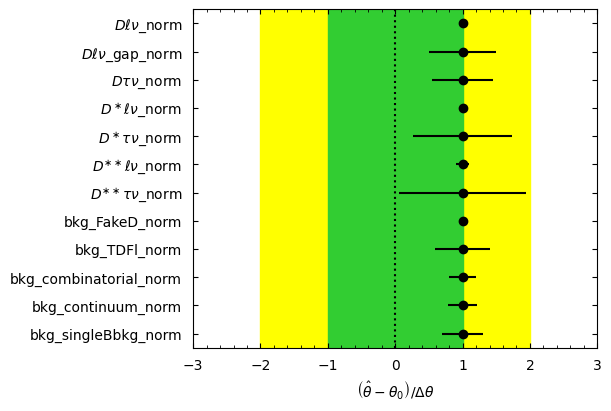

In [22]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


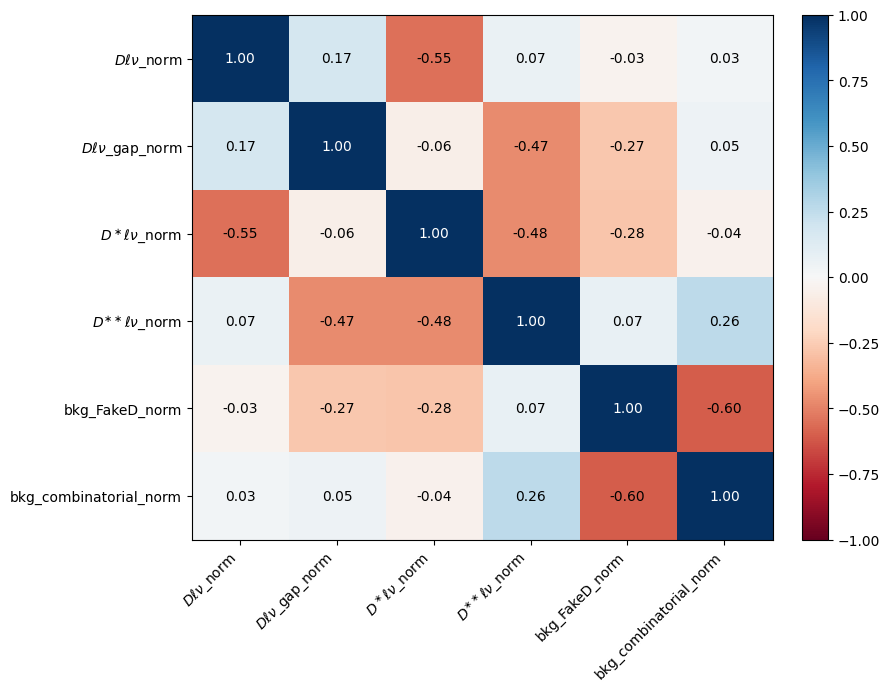

In [28]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.35)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


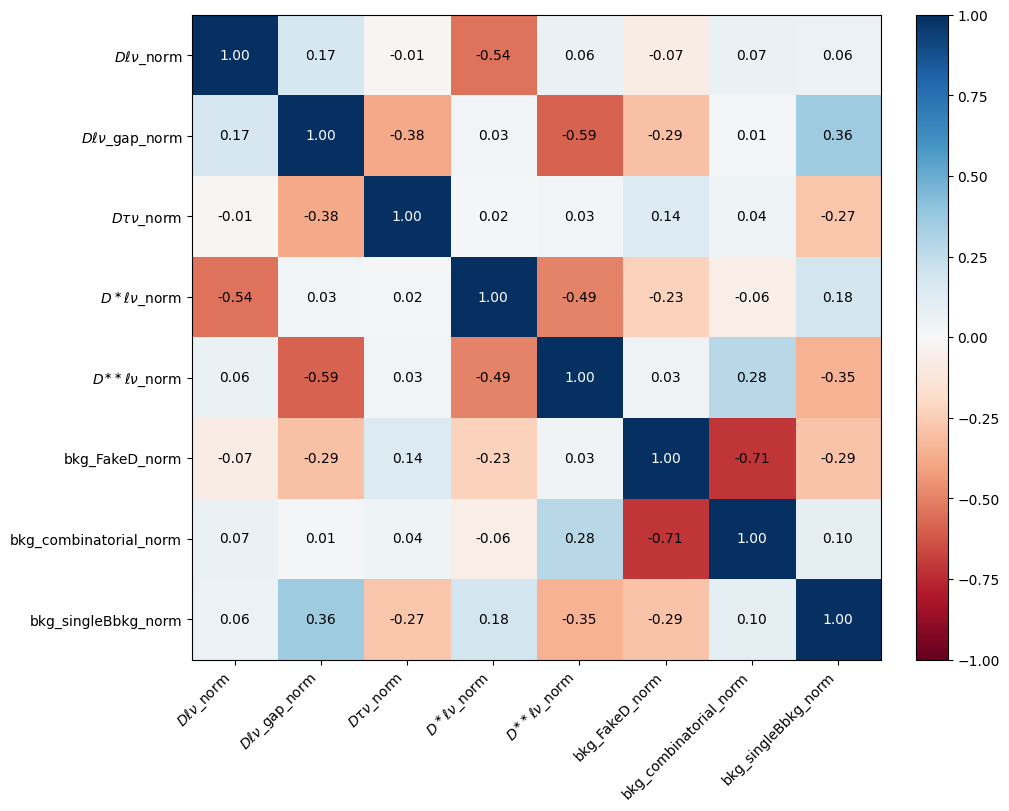

In [16]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.33)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │              Nfcn = 73               │
│ EDM = 2.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3955.304735 at

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3960                       │        Nfcn = 101, Ngrad = 9         │
│ EDM = 0.000513 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3960.403538 at

DEBUG - cabinetry.fit - -2 log(L) = 3957.894671 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.565
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3958                       │         Nfcn = 99, Ngrad = 8         │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3956.059152 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.778
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │        Nfcn = 101, Ngrad = 8         │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.321419 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.990
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │         Nfcn = 75, Ngrad = 2         │
│ EDM = 0.000493 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.679596 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.202
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │         Nfcn = 95, Ngrad = 8         │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3957.135240 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.414
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3957                       │         Nfcn = 98, Ngrad = 9         │
│ EDM = 6.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3959.692705 at best-fit point
INFO - cabinetry.visualize.utils - saving figure as figures/scan_$D\tau\nu$_norm.pdf


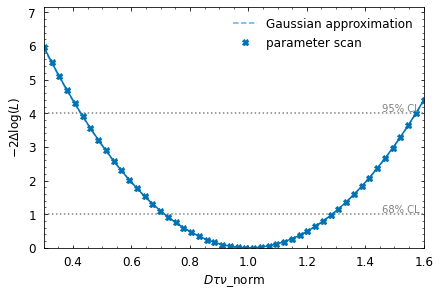

In [80]:
scan_0=cabinetry.fit.scan(model=model, data=data,par_name=r'$D\tau\nu$_norm',par_range=[0.3,1.6],n_steps=50)
cabinetry.visualize.scan(scan_0)

INFO - cabinetry.visualize.utils - saving figure as figures/electron_postfit.pdf


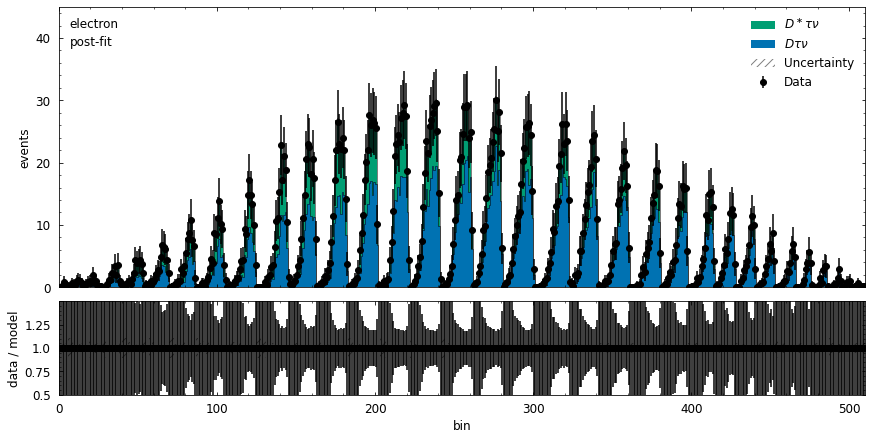

In [105]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)
for i in _:
    i['figure'].set_figwidth(12)

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 